# Imports


In [1]:
import os
import sys
import pickle
import json
from torch import nn
import torch
from openai import OpenAI
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    pipeline,
    AutoModel,
    set_seed,
)

# File Path Declaration


In [2]:
project_base_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
project_base_path

'/home/ANONYMOUS/projects/FALCON'

In [3]:
sys.path.append(project_base_path)
from src.validator.syntactic.snort.snortparser import (
    snort_syntax_checker,
    basic_snort_rule_parser,
)
from src.validator.semantic.snort.snort_semantic_validator import (
    snort_semantic_evaluator,
    get_relevant_rules_semantic_scores_for_input_cti,
)
from src.validator.performance.snort.snort_performance_evaluator import (
    evaluate as snort_performance_evaluator,
)

In [4]:
saved_v1_generated_data_path = os.path.join(
    project_base_path, "data/generation/snort/snort3-community-rules_v1.pkl"
)
saved_v1_generated_data_path

'/home/ANONYMOUS/projects/FALCON/data/generation/snort/snort3-community-rules_v1.pkl'

In [5]:
saved_v2_generated_data_path = os.path.join(
    project_base_path, "data/generation/snort/snort3-community-rules_v2.pkl"
)
saved_v2_generated_data_path

'/home/ANONYMOUS/projects/FALCON/data/generation/snort/snort3-community-rules_v2.pkl'

In [6]:
relevant_snort_data_path = os.path.join(
    project_base_path, "data/generation/dummy_snort/dummy_snort_rules_v1.pkl"
)
relevant_snort_data_path

'/home/ANONYMOUS/projects/FALCON/data/generation/dummy_snort/dummy_snort_rules_v1.pkl'

In [7]:
generated_rule_dir_path = os.path.join(
    project_base_path,
    "results/end-to-end_quantitative/generated_data/snort/Llama-3.3-70B-Instruct",
)
generated_rule_dir_path

'/home/ANONYMOUS/projects/FALCON/results/end-to-end_quantitative/generated_data/snort/Llama-3.3-70B-Instruct'

# Environment


In [8]:
SEED = 42
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
MAX_LEN = 512

# Llama 3.3 70B Environment
model_path = "/data/common/models/meta-llama/Llama-3.3-70B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_path,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Device set to use cuda:0


In [9]:
def get_llama_33_output(prompt: str) -> str:
    messages = [{"role": "user", "content": prompt}]

    outputs = pipeline(
        messages,
        max_new_tokens=4096,
    )

    torch.cuda.empty_cache()

    return outputs[0]["generated_text"][-1]["content"]

In [10]:
print(get_llama_33_output("Who are you?"))

I'm an artificial intelligence model known as Llama. Llama stands for "Large Language Model Meta AI."


### Load FALCON CTI-Rule Semantic Validator Model


In [4]:
# Configurations for Snort Semantic Validator
FINE_TUNED_MODEL_NAME = "all-mpnet-base-v2"
MODEL_NAME = f"/data/common/models/sentence-transformers/{FINE_TUNED_MODEL_NAME}"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RUN = 2
###########################
MAX_LEN = 512
FINE_TUNED_MODEL_STATE_NAME = f"contrastive_encoder_r{RUN}.pt"
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

MODEL_LOAD_PATH = os.path.join(
    project_base_path,
    f"script/fine_tuning/bi-encoder/snort/{FINE_TUNED_MODEL_NAME}/{FINE_TUNED_MODEL_STATE_NAME}",
)

In [5]:
# Bi-Encoder Model
class SentenceEncoder(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0]  # CLS token
        return nn.functional.normalize(
            embeddings, p=2, dim=1
        )  # Normalize for cosine similarity

In [6]:
# Load tokenizer and model
# Load tokenizer
cti_rule_semantic_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load model
cti_rule_semantic_model = SentenceEncoder(MODEL_NAME).to(DEVICE)
cti_rule_semantic_model.load_state_dict(
    torch.load(MODEL_LOAD_PATH, map_location=DEVICE)
)
print(f"Loaded fine-tuned model from {MODEL_LOAD_PATH}")

Loaded fine-tuned model from /home/ANONYMOUS/projects/FALCON/script/fine_tuning/bi-encoder/snort/all-mpnet-base-v2/contrastive_encoder_r2.pt


# Helper Functions


In [14]:
def load_from_pickle(file_path) -> dict:
    """
    Loads data from a pickle file.

    :param file_path: Path to the pickle file
    :return: Loaded data
    """
    try:
        with open(file_path, "rb") as file:
            return pickle.load(file)
    except Exception as e:
        print(f"Error loading data from pickle: {e}")
        return None

In [15]:
def get_first_n_elements(dictionary: dict, n: int) -> dict:
    """
    Get the first n elements of a dictionary.

    :param dictionary: The input dictionary
    :param n: The number of elements to retrieve
    :return: A dictionary with the first n elements
    """
    return dict(list(dictionary.items())[:n])

In [16]:
def save_string_as_txt(directory_path, file_name, content):
    """
    Saves a given string as a .txt file in the specified directory.

    Args:
        directory_path (str): Path to the directory where the file should be saved.
        file_name (str): Desired name of the file (with or without .txt extension).
        content (str): The string content to be written to the file.

    Returns:
        str: Full path to the saved file if successful, otherwise an empty string.
    """
    if not file_name.lower().endswith(".txt"):
        file_name += ".txt"

    file_path = os.path.join(directory_path, file_name)

    try:
        os.makedirs(
            directory_path, exist_ok=True
        )  # Create directory if it doesn't exist
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(content)
        return file_path
    except PermissionError:
        print(f"Error: Permission denied to write to '{file_path}'.")
    except Exception as e:
        print(f"An error occurred while saving the file: {e}")

    return ""

# Data Generation


In [17]:
# Load the data back from the pickle file
loaded_v1_data = load_from_pickle(saved_v1_generated_data_path)
print(len(loaded_v1_data.keys()))

4017


In [18]:
snort_cti_sample_dict = get_first_n_elements(loaded_v1_data, 10)

In [19]:
# Load the data back from the pickle file
loaded_v2_data = load_from_pickle(saved_v2_generated_data_path)
print(len(loaded_v2_data.keys()))

4017


In [20]:
snort_cti_sample_dict

{'alert tcp $HOME_NET 2589 -> $EXTERNAL_NET any ( msg:"MALWARE-BACKDOOR - Dagger_1.4.0"; flow:to_client,established; content:"2|00 00 00 06 00 00 00|Drives|24 00|",depth 16; metadata:ruleset community; classtype:misc-activity; sid:105; rev:14; )': '    Title: Detection of Dagger 1.4.0 Backdoor Activity Over TCP\n\n    Threat Category: Malware – Backdoor\n\n    Threat Name: Dagger 1.4.0\n\n    Detection Summary:\n\n    This signature is designed to detect network traffic associated with the Dagger 1.4.0 backdoor. The traffic is characterized by a specific sequence of bytes ("2|00 00 00 06 00 00 00|Drives|24 00|") found within the first 16 bytes of the data payload. This communication occurs from an infected internal host to an external destination and typically indicates unauthorized remote access capabilities.\n\n    Rule Metadata\n    Classification: Misc Activity\n\n    Ruleset: Community\n\n    Rule Logic Breakdown\n    Alert Type: alert\n\n    Protocol: tcp\n\n    Source IP: $HOME_

In [21]:
snorts, ctis = zip(*snort_cti_sample_dict.items())
snorts = list(snorts)
ctis = list(ctis)

In [22]:
len(snorts), len(ctis)

(10, 10)

In [23]:
loaded_dummy_snort_rules = load_from_pickle(relevant_snort_data_path)
len(loaded_dummy_snort_rules.keys())

4017

In [24]:
def format_cti_snort_data_to_training_data(data: list[dict]) -> list[tuple]:
    """
    Format the CTI Snort data into training data.

    :param data: The data to format
    :return: Formatted training data
    """
    training_data = []
    for dataset in data:
        for key, value in dataset.items():
            training_data.append((key, value))
    return training_data

In [25]:
# Sample Dataset Format (list of (anchor, positive) sentence pairs)
full_dataset = format_cti_snort_data_to_training_data(
    [loaded_v1_data, loaded_v2_data]
)
print(len(full_dataset))

8034


In [26]:
def remove_10_test_samples(training_data: list[tuple], test_pairs: dict) -> list[tuple]:
    # Extract all test keys and values into sets for quick lookup
    test_keys = set(test_pairs.keys())
    test_values = set(test_pairs.values())

    # Filter training data
    filtered_data = [
        (key, value)
        for key, value in training_data
        if key not in test_keys and value not in test_values
    ]

    return filtered_data

In [27]:
# Sample Dataset Format (list of (anchor, positive) sentence pairs)
full_dataset = remove_10_test_samples(full_dataset, snort_cti_sample_dict)
print(len(full_dataset))

8014


In [28]:
# Split into training and testing sets (80% train, 20% test)
train_pairs, test_pairs = train_test_split(
    full_dataset, test_size=0.1, random_state=SEED
)

In [29]:
len(test_pairs)

802

# Dataset Class


In [30]:
# Custom Dataset
class ContrastiveDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        anchor, positive = self.data[idx]
        encoded = self.tokenizer(
            [anchor, positive],
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt",
        )
        return {
            "input_ids_a": encoded["input_ids"][0],
            "attention_mask_a": encoded["attention_mask"][0],
            "input_ids_b": encoded["input_ids"][1],
            "attention_mask_b": encoded["attention_mask"][1],
        }

In [31]:
# Bi-Encoder Model
class SentenceEncoder(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0]  # CLS token
        return nn.functional.normalize(
            embeddings, p=2, dim=1
        )  # Normalize for cosine similarity

# Evaluation Functions


In [32]:
def format_performance_feedback_for_improvement(performance_result: dict) -> str:
    """
    Converts raw performance metrics into actionable improvement suggestions.

    Args:
        performance_result: Dictionary containing performance metrics

    Returns:
        Formatted string with specific improvement suggestions
    """
    if not performance_result:
        return "No performance feedback available."

    score = performance_result.get("score", 0)
    issues = performance_result.get("issues", [])
    metrics = performance_result.get("metrics", {})

    feedback_lines = [
        f"Current Performance Score: {score}/20",
        f"Risk Classification: {performance_result.get('risk_classification', 'Unknown')}",
    ]

    # Specific improvement suggestions based on issues
    if issues:
        feedback_lines.append("\n**Issues Detected:**")
        for issue in issues:
            feedback_lines.append(f"  - {issue}")

        feedback_lines.append("\n**Recommended Improvements:**")

        # Provide specific fixes for common issues
        for issue in issues:
            if "PCRE" in issue or "regex" in issue.lower():
                feedback_lines.append(
                    "  → Simplify or remove complex PCRE patterns. Use 'content' matches when possible."
                )
            elif "negation" in issue.lower():
                feedback_lines.append(
                    "  → Avoid negated content matches. Rewrite logic positively."
                )
            elif "recursive" in issue.lower():
                feedback_lines.append(
                    "  → Remove recursive distance/within modifiers to reduce backtracking."
                )
            elif "depth" in issue.lower() or "offset" in issue.lower():
                feedback_lines.append(
                    "  → Use fixed depth/offset values instead of computed ones when possible."
                )
            elif "content" in issue.lower() and "multiple" in issue.lower():
                feedback_lines.append(
                    "  → Reduce number of content matches. Combine or prioritize most specific patterns."
                )
            elif "distance" in issue.lower() or "within" in issue.lower():
                feedback_lines.append(
                    "  → Minimize use of distance/within. Use specific offsets when known."
                )

    # Add metric-specific guidance
    if metrics:
        feedback_lines.append("\n**Performance Metrics:**")
        for key, value in metrics.items():
            feedback_lines.append(f"  {key}: {value}")

    return "\n".join(feedback_lines)

In [33]:
def generate_rule_from_cti_prompt_and_relevant_rules_and_feedback(
    input_cti: str, relevant_rules: list, feedback: dict | None = None
) -> str:

    # Format performance feedback with actionable suggestions
    performance_feedback = ""
    if feedback and feedback.get("performance"):
        performance_feedback = format_performance_feedback_for_improvement(
            feedback["performance"]
        )
    else:
        performance_feedback = "No Performance feedback provided."

    rule_generation_prompt = f"""

    You are an expert in Cyber Threat Intelligence (CTI) and Intrusion Detection Systems with specialization in Snort rule development.

    Your task is to generate a Snort detection rule strictly from the provided CTI input.  
    You must infer rule components logically while ensuring they are supported ONLY by information present in the CTI.  
    Avoid assumptions not grounded in the CTI context.

    Below is a reference example illustrating format, structure, and reasoning:
    
    Sample CTI Input and corresponding Snort Output:

    ##########################
    CTI Input:
        
      Title: Detection of QAZ Worm Client Login Activity over TCP Port 7597

      Threat Category: Malware – Backdoor

      Threat Name: QAZ Worm

      Detection Summary:

      This signature is designed to detect network traffic associated with the QAZ Worm, specifically its client login activity. The worm exhibits characteristic behavior by initiating a connection and transmitting a unique identifier string (qazwsx.hsq) to a remote server over TCP port 7597. This communication typically indicates the presence of a backdoor that allows unauthorized access to infected systems.

      Rule Metadata
      Classification: Misc Activity

      Ruleset: Community

      Rule Logic Breakdown
      Alert Type: alert

      Protocol: tcp

      Source IP: $EXTERNAL_NET (any IP address outside the local trusted network)

      Source Port: any

      Destination IP: $HOME_NET (any IP address inside the local trusted network)

      Destination Port: 7597 (known port used by the QAZ worm)

      Flow: to_server, established
      (Traffic must be flowing to a server and part of an established connection)

      Content Match: "qazwsx.hsq"
      (String in the payload that identifies the worm's presence)

      Message: "MALWARE-BACKDOOR QAZ Worm Client Login access"

      Technical Details
      Port 7597 is not a standard well-known port and is leveraged by the QAZ Worm for backdoor communications.

      The content string "qazwsx.hsq" is a unique identifier used by the worm's client when connecting to a command-and-control server or to another infected host.

      Detection relies on the presence of this string within an established TCP session directed to a host on the internal network.

      Indicators of Compromise (IOCs)
      String Pattern: qazwsx.hsq

      Destination Port: 7597/tcp

      Recommended Actions
      Block or restrict traffic on port 7597 at the perimeter firewall.

      Investigate any internal systems that initiate or receive such connections.

      Perform malware scanning and forensic analysis on potentially compromised hosts.

      Update endpoint and network defense signatures to ensure coverage against this and similar threats.
    
    ##########################
    Corresponding Snort Rule Output:
        
      alert tcp $EXTERNAL_NET any -> $HOME_NET 7597 ( msg:"MALWARE-BACKDOOR QAZ Worm Client Login access"; flow:to_server,established; content:"qazwsx.hsq"; metadata:ruleset community; classtype:misc-activity; sid:108; rev:12; )


    ### **Critical Constraints**

    1. **Output ONLY the final Snort rule** — no explanations, no commentary, no code blocks.
    2. The rule MUST be a single line starting with 'alert'
    3. Use ONLY information present in the CTI - do not invent indicators
    4. Address ALL feedback provided below to improve the rule

    ### **Your Output Requirements**

    Rule must include:
      - Action (`alert`)
      - Protocol (tcp/udp/ip/http etc., based strictly on CTI)
      - Source & destination address spaces
      - Ports (if specified in CTI)
      - Payload/content signatures (strings, hex, URIs, file patterns, etc.)
      - Flow/flags if activity directionality is implied
      - Metadata, classification, SID, revision


    ### Input to Process

    ##########################
    CTI Input:
    {input_cti}

    ##########################
    Relevant Snort Rules (for reference—not to be copied):
    {chr(10).join(relevant_rules) if relevant_rules else "No relevant rules provided."}

    ##########################
    **Previous Generated Rule:**
    {feedback['previous_rule'] if feedback and feedback.get('previous_rule') else "No previous rule provided. This is the first attempt."}
    
    ### **Feedback for Improvement**
    
    **Syntax Feedback:**
    {feedback['syntax'] if feedback and feedback.get('syntax') else "No Syntax feedback provided."}
    
    **Semantic Feedback:**
    Measures rule effectiveness against input CTI. Score range: [0-1]
    **Your Goal:** Maximize this score to ensure the generated rule effectively detects the threat.
    Previous Generated Rules and Corresponding Semantic Scores:
    {json.dumps(feedback['semantic'], indent=2) if feedback and feedback.get('semantic') else "No Semantic feedback provided."}
    
    **Performance Feedback:**
    {performance_feedback}
    
    
    ##########################
    ### **Generate Improved Snort Rule Below**
    
    Based on the feedback above, generate an improved rule that:
    - Remains syntactically valid
    - Maintains detection effectiveness (high semantic score > 0.9)
    - Reduces performance complexity (lower score is better, target: 0-3)
    
    Output only the final Snort rule on a single line with no additional text:
    
  """

    return rule_generation_prompt

In [34]:
def get_relevant_rules_from_dummy_dict(input_rule: str, dummy_rules_dict: dict) -> list:
    """
    Get relevant rules from dummy snort dict.

    :param input_rule: The input CTI
    :param dummy_rules_dict: The dummy snort dict
    :return: List of relevant rules
    """
    relevant_rules = dummy_rules_dict.get(input_rule, [])

    return relevant_rules

# Test Code


In [41]:
test_ctis = [i[1] for i in test_pairs]
test_ctis[0]

'Title: Detection of Microsoft Compound File Binary v3 File Magic\n\nThreat Category: File Identification\n\nThreat Name: Microsoft Compound File Binary v3\n\nDetection Summary:\n\nThis signature is designed to detect network traffic associated with Microsoft Compound File Binary v3 files, specifically the file magic that identifies these files. The detection exhibits characteristic behavior by identifying a unique binary pattern within the file data transmitted over the network. This identification typically indicates the presence of a Microsoft Compound File Binary v3 file being transferred.\n\nRule Metadata\nClassification: Misc Activity\n\nRuleset: Community\n\nRule Logic Breakdown\nAlert Type: alert\n\nProtocol: tcp\n\nSource IP: $EXTERNAL_NET (any IP address outside the local trusted network)\n\nSource Port: $FILE_DATA_PORTS (common ports used for file transfers)\n\nDestination IP: $HOME_NET (any IP address inside the local trusted network)\n\nDestination Port: any\n\nFlow: to_cl

In [42]:
test_gt_rules = [i[0] for i in test_pairs]
test_gt_rules[0]

'alert tcp $EXTERNAL_NET $FILE_DATA_PORTS -> $HOME_NET any ( msg:"FILE-IDENTIFY Microsoft Compound File Binary v3 file magic detected"; flow:to_client,established; file_data; content:"|D0 CF 11 E0 A1 B1 1A E1|"; content:">|00 03 00|",within 4,distance 16; flowbits:set,file.ole; flowbits:noalert; metadata:policy balanced-ips alert,policy connectivity-ips alert,policy max-detect-ips alert,policy security-ips alert,ruleset community; service:ftp-data,http,imap,pop3; classtype:misc-activity; sid:16474; rev:27; )'

In [43]:
test_dummy_rules = get_relevant_rules_from_dummy_dict(
    test_gt_rules[0], loaded_dummy_snort_rules
)
test_dummy_rules

['alert tcp $EXTERNAL_NET $FILE_DATA_PORTS -> $HOME_NET 143 (msg:"Suspicious file transfer via IMAP"; flow:to_client,established; file_data; content:"|D0 CF 11 E0 A1 B1 1A E1|"; content:"|00 02 00|",within 4,distance 16; classtype:bad-unknown;)',
 'alert tcp $EXTERNAL_NET $FILE_DATA_PORTS -> $HOME_NET any (msg:"Unusual CFB-like traffic detected"; flow:to_client,established; content:"|D0 CF 11|"; classtype:trojan-activity;)',
 'alert tcp $EXTERNAL_NET $FILE_DATA_PORTS -> $HOME_NET 110 (msg:"Possible malicious CFB file over POP3"; flow:to_client,established; file_data; content:"|D0 CF 11 E0 A1 B1 1A E1|"; classtype:misc-activity;)']

In [45]:
prompt = generate_rule_from_cti_prompt_and_relevant_rules_and_feedback(
    test_ctis[0], relevant_rules=test_dummy_rules, feedback=None
)
print(prompt)



    You are an expert in Cyber Threat Intelligence (CTI) and Intrusion Detection Systems with specialization in Snort rule development.

    Your task is to generate a Snort detection rule strictly from the provided CTI input.  
    You must infer rule components logically while ensuring they are supported ONLY by information present in the CTI.  
    Avoid assumptions not grounded in the CTI context.

    Below is a reference example illustrating format, structure, and reasoning:
    
    Sample CTI Input and corresponding Snort Output:

    ##########################
    CTI Input:
        
      Title: Detection of QAZ Worm Client Login Activity over TCP Port 7597

      Threat Category: Malware – Backdoor

      Threat Name: QAZ Worm

      Detection Summary:

      This signature is designed to detect network traffic associated with the QAZ Worm, specifically its client login activity. The worm exhibits characteristic behavior by initiating a connection and transmitting a unique

In [46]:
test_rule = get_llama_33_output(prompt)
print(test_rule)

alert tcp $EXTERNAL_NET $FILE_DATA_PORTS -> $HOME_NET any (msg:"FILE-IDENTIFY Microsoft Compound File Binary v3 file magic detected"; flow:to_client,established; content:"|D0 CF 11 E0 A1 B1 1A E1|"; content:">|00 03 00|",within 4,distance 16; metadata:ruleset community; classtype:misc-activity; sid:109; rev:1;)


In [47]:
test_feedback = {}

In [48]:
test_feedback["syntax"] = snort_syntax_checker(test_rule)
print(test_feedback)

{'syntax': {'status': True, 'error_comment': 'No syntax errors detected.'}}


In [49]:
test_feedback["semantic"] = snort_semantic_evaluator(
    test_rule,
    [test_gt_rules[0]],
    tokenizer=cti_rule_semantic_tokenizer,
    model=cti_rule_semantic_model,
)
print(json.dumps(test_feedback, indent=2))

{
  "syntax": {
    "status": true,
    "error_comment": "No syntax errors detected."
  },
  "semantic": {
    "rule": "alert tcp $EXTERNAL_NET $FILE_DATA_PORTS -> $HOME_NET any (msg:\"FILE-IDENTIFY Microsoft Compound File Binary v3 file magic detected\"; flow:to_client,established; content:\"|D0 CF 11 E0 A1 B1 1A E1|\"; content:\">|00 03 00|\",within 4,distance 16; metadata:ruleset community; classtype:misc-activity; sid:109; rev:1;)",
    "scores": [
      0.9927775263786316
    ],
    "status": true
  }
}


In [50]:
test_feedback["performance"] = snort_performance_evaluator(test_rule)
print(json.dumps(test_feedback, indent=2))

{
  "syntax": {
    "status": true,
    "error_comment": "No syntax errors detected."
  },
  "semantic": {
    "rule": "alert tcp $EXTERNAL_NET $FILE_DATA_PORTS -> $HOME_NET any (msg:\"FILE-IDENTIFY Microsoft Compound File Binary v3 file magic detected\"; flow:to_client,established; content:\"|D0 CF 11 E0 A1 B1 1A E1|\"; content:\">|00 03 00|\",within 4,distance 16; metadata:ruleset community; classtype:misc-activity; sid:109; rev:1;)",
    "scores": [
      0.9927775263786316
    ],
    "status": true
  },
  "performance": {
    "score": 5,
    "risk_level": "Needs Optimization",
    "reasons": [
      "Multiple content matches without depth/offset/within constraints",
      "Overlapping content patterns detected: ['\\'|D0 CF 11 E0 A1 B1 1A E1|\\' and \\'>|00 03 00|\",within 4,distance 16\\'']"
    ],
    "suggestions": [
      "Add 'depth', 'offset', 'within', or 'distance' to anchor content searches",
      "Remove redundant content matches or consolidate patterns"
    ]
  }
}


In [51]:
prompt = generate_rule_from_cti_prompt_and_relevant_rules_and_feedback(
    test_ctis[9], relevant_rules=test_dummy_rules, feedback=test_feedback
)
print(prompt)



    You are an expert in Cyber Threat Intelligence (CTI) and Intrusion Detection Systems with specialization in Snort rule development.

    Your task is to generate a Snort detection rule strictly from the provided CTI input.  
    You must infer rule components logically while ensuring they are supported ONLY by information present in the CTI.  
    Avoid assumptions not grounded in the CTI context.

    Below is a reference example illustrating format, structure, and reasoning:
    
    Sample CTI Input and corresponding Snort Output:

    ##########################
    CTI Input:
        
      Title: Detection of QAZ Worm Client Login Activity over TCP Port 7597

      Threat Category: Malware – Backdoor

      Threat Name: QAZ Worm

      Detection Summary:

      This signature is designed to detect network traffic associated with the QAZ Worm, specifically its client login activity. The worm exhibits characteristic behavior by initiating a connection and transmitting a unique

# Generate Rule from CTI


In [ ]:
generated_rules = []

inference_counter = 0
retry_limit = 15
for cti, gt_rule in tqdm(
    zip(test_ctis, test_gt_rules), "Generating Snort rules from CTIs..."
):

    # Get relevant rules
    relevant_rules = get_relevant_rules_from_dummy_dict(
        gt_rule, loaded_dummy_snort_rules
    )
    # Get relevant rules semantic scores
    relevant_rules_semantic_scores = get_relevant_rules_semantic_scores_for_input_cti(
        cti,
        relevant_rules,
        model=cti_rule_semantic_model,
        tokenizer=cti_rule_semantic_tokenizer,
    )
    # print(f"Relevant Rules Semantic Scores: {relevant_rules_semantic_scores}")
    # Determine minimum semantic score threshold
    min_semantic_score_threshold = (
        max(max(relevant_rules_semantic_scores), 0.9)
        if relevant_rules_semantic_scores
        else 0.9
    )
    # print(f"Minimum Semantic Score Threshold: {min_semantic_score_threshold}")
    # Initialize feedback and retry counter
    feedback = {}
    retry_counter = 0
    # Flag to track one-shot inference
    is_one_shot_inference = True
    reuse_one_shot_results = False
    # Prepare evaluation dict
    evaluation_dict = {"cti": cti, "ground_truth_rule": gt_rule}
    rule = None

    # Retry loop
    while retry_counter < retry_limit:
        # Generate rule
        prompt = generate_rule_from_cti_prompt_and_relevant_rules_and_feedback(
            cti, relevant_rules=relevant_rules, feedback=feedback
        )
        # # Test Print Prompt
        # print(prompt)
        rule = get_llama_33_output(prompt)
        feedback["previous_rule"] = rule

        if is_one_shot_inference is True:

            # One-shot inference evaluation
            feedback["syntax"] = snort_syntax_checker(rule)
            feedback["semantic"] = [
                snort_semantic_evaluator(
                    rule,
                    [gt_rule],
                    tokenizer=cti_rule_semantic_tokenizer,
                    model=cti_rule_semantic_model,
                    threshold=min_semantic_score_threshold,
                )
            ]
            feedback["performance"] = snort_performance_evaluator(rule)

            evaluation_dict["one_shot_inference"] = {
                "feedback": feedback,
                "generated_rule": rule,
            }
            # Reuse one-shot results flag
            reuse_one_shot_results = True
            # Set one-shot inference feedback to False after first iteration
            is_one_shot_inference = False

        # Validation

        # Check for syntax correctness
        feedback["syntax"] = snort_syntax_checker(rule)

        # Check for syntaxtic correctness
        if feedback["syntax"].get("status", False) is True:
            # print("Passed Syntax Check - Proceed to Semantic Evaluation")

            if reuse_one_shot_results:
                reuse_one_shot_results = False
            else:
                feedback["semantic"].append(
                    snort_semantic_evaluator(
                        rule,
                        [cti],
                        threshold=min_semantic_score_threshold,
                        model=cti_rule_semantic_model,
                        tokenizer=cti_rule_semantic_tokenizer,
                    )
                )
            # Check for semantic correctness
            semantic_score_to_check = feedback["semantic"][-1].get("scores", [0.0])
            # print(f"Semantic Score to Check: {semantic_score_to_check[0]}")
            if semantic_score_to_check[0] > min_semantic_score_threshold:

                # print("Passed Semantic Check - Proceed to Performance Evaluation")
                # Passed Semantic Check - Proceed
                feedback["performance"] = snort_performance_evaluator(rule)

                if feedback["performance"].get("score", 10) <= 20:
                    # Passed Performance Check - Accept Rule

                    # Append final rule to list
                    evaluation_dict["final_inference"] = {
                        "feedback": feedback,
                        "generated_rule": rule,
                        "no_of_retries": retry_counter,
                        "status": True,
                    }
                    generated_rules.append(evaluation_dict)
                    file_name = f"e2e_generated_snort_rule_{inference_counter}.txt"
                    save_string_as_txt(generated_rule_dir_path, file_name, rule)
                    if retry_counter > 0:
                        print(
                            f"Rule accepted for CTI index {inference_counter} after {retry_counter} retries."
                        )
                    inference_counter += 1
                    break

                else:
                    # Failed Performance Check - Retry
                    retry_counter += 1
                    print(feedback["performance"])
                    print(
                        f"Retrying... Attempt {retry_counter} for CTI index {inference_counter}"
                    )

            else:
                # Failed Semantic Check - Retry
                retry_counter += 1
                print(feedback["semantic"])
                print(
                    f"Retrying... Attempt {retry_counter} for CTI index {inference_counter}"
                )

        else:
            # Failed Syntax Check - Retry
            retry_counter += 1
            print(feedback["syntax"])
            print(
                f"Retrying... Attempt {retry_counter} for CTI index {inference_counter}"
            )
    else:
        # Append final rule to list
        evaluation_dict["final_inference"] = {
            "feedback": feedback,
            "generated_rule": rule,
            "no_of_retries": retry_counter,
            "status": False,
        }
        generated_rules.append(evaluation_dict)

Generating Snort rules from CTIs...: 7it [01:07, 10.10s/it]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Generating Snort rules from CTIs...: 30it [04:49,  9.17s/it]

[{'rule': 'alert tcp $EXTERNAL_NET any -> $HOME_NET $HTTP_PORTS ( msg:"SERVER-OTHER Apache Log4j logging remote code execution attempt"; flow:to_server,established; content:"jndi"; metadata:ruleset community; classtype:attempted-user; sid:109; rev:1; )', 'scores': [0.8872609734535217], 'status': False}]
Retrying... Attempt 1 for CTI index 30


Generating Snort rules from CTIs...: 31it [05:05, 11.15s/it]

Rule accepted for CTI index 30 after 1 retries.


Generating Snort rules from CTIs...: 35it [05:38,  9.09s/it]

[{'rule': 'alert tcp $HOME_NET any -> $EXTERNAL_NET $HTTP_PORTS ( msg:"MALWARE-CNC Win.Trojan.ExplorerHijack variant outbound connection"; flow:to_server,established; content:"GET"; http_method; content:"/prl/el.html"; http_uri; content:"User-Agent: Mozilla/3.0 (compatible; Indy Library)"; http_header; nocase; metadata:ruleset community; classtype:trojan-activity; sid:109; rev:1; )', 'scores': [0.8497011661529541], 'status': False}]
Retrying... Attempt 1 for CTI index 35


Generating Snort rules from CTIs...: 36it [06:02, 13.34s/it]

Rule accepted for CTI index 35 after 1 retries.


Generating Snort rules from CTIs...: 99it [16:17,  9.25s/it]

{'status': False, 'error_comment': 'Syntax error: Invalid Snort rule syntax.'}
Retrying... Attempt 1 for CTI index 99


Generating Snort rules from CTIs...: 100it [16:40, 13.64s/it]

Rule accepted for CTI index 99 after 1 retries.


Generating Snort rules from CTIs...: 155it [25:41, 10.90s/it]

[{'rule': 'alert tcp $EXTERNAL_NET $FILE_DATA_PORTS -> $HOME_NET any (msg:"FILE-IDENTIFY Portable Executable download detected"; flow:to_client,established; content:"|4d 5a|"; file_data; content:"application/x-msdos-program"; http_header; metadata:ruleset community; classtype:misc-activity; sid:109; rev:1;)', 'scores': [0.8343017101287842], 'status': False}]
Retrying... Attempt 1 for CTI index 155


Generating Snort rules from CTIs...: 156it [25:59, 13.04s/it]

Rule accepted for CTI index 155 after 1 retries.


Generating Snort rules from CTIs...: 174it [28:57, 10.04s/it]

[{'rule': 'alert tcp $HOME_NET any -> $EXTERNAL_NET $HTTP_PORTS ( msg:"MALWARE-CNC Win.Trojan.Mevade variant outbound connection"; flow:to_server,established; content:"|0D 0A|uuid: "; http_client_body; metadata:ruleset community; classtype:trojan-activity; sid:109; rev:1; )', 'scores': [0.8342583179473877], 'status': False}]
Retrying... Attempt 1 for CTI index 174


Generating Snort rules from CTIs...: 175it [29:15, 12.40s/it]

Rule accepted for CTI index 174 after 1 retries.


Generating Snort rules from CTIs...: 241it [40:35, 11.54s/it]

[{'rule': 'alert tcp $HOME_NET any -> $EXTERNAL_NET $HTTP_PORTS ( msg:"MALWARE-CNC Win.Trojan.Qakbot variant outbound connection"; flow:to_server,established; content:"btst="; content:"snkz="; content:"Accept|3A 20|application/x-shockwave-flash, image/gif, image/jpeg, image/pjpeg, */*|0D 0A|"; content:"Cache-Control|3A 20|no-cache|0D 0A|"; metadata:ruleset community; classtype:trojan-activity; sid:109; rev:1; )', 'scores': [0.8885514736175537], 'status': False}]
Retrying... Attempt 1 for CTI index 241


Generating Snort rules from CTIs...: 242it [41:04, 16.96s/it]

Rule accepted for CTI index 241 after 1 retries.


Generating Snort rules from CTIs...: 266it [44:57,  9.69s/it]

[{'rule': 'alert tcp $EXTERNAL_NET any -> $HOME_NET $HTTP_PORTS ( msg:"SERVER-OTHER Apache Log4j logging remote code execution attempt"; flow:to_server,established; content:"${jndi"; metadata:ruleset community; classtype:attempted-user; sid:109; rev:1; )', 'scores': [0.28303515911102295], 'status': False}]
Retrying... Attempt 1 for CTI index 266
[{'rule': 'alert tcp $EXTERNAL_NET any -> $HOME_NET $HTTP_PORTS ( msg:"SERVER-OTHER Apache Log4j logging remote code execution attempt"; flow:to_server,established; content:"${jndi"; metadata:ruleset community; classtype:attempted-user; sid:109; rev:1; )', 'scores': [0.28303515911102295], 'status': False}, {'rule': 'alert tcp $EXTERNAL_NET any -> $HOME_NET $HTTP_PORTS ( msg:"SERVER-OTHER Apache Log4j logging remote code execution attempt"; flow:to_server,established; content:"${jndi"; nocase; metadata:ruleset community; classtype:attempted-user; sid:110; rev:2; )', 'scores': [0.4290492832660675], 'status': False}]
Retrying... Attempt 2 for CTI 

Generating Snort rules from CTIs...: 267it [47:05, 45.29s/it]

[{'rule': 'alert tcp $EXTERNAL_NET any -> $HOME_NET $HTTP_PORTS ( msg:"SERVER-OTHER Apache Log4j logging remote code execution attempt"; flow:to_server,established; content:"${jndi"; metadata:ruleset community; classtype:attempted-user; sid:109; rev:1; )', 'scores': [0.28303515911102295], 'status': False}, {'rule': 'alert tcp $EXTERNAL_NET any -> $HOME_NET $HTTP_PORTS ( msg:"SERVER-OTHER Apache Log4j logging remote code execution attempt"; flow:to_server,established; content:"${jndi"; nocase; metadata:ruleset community; classtype:attempted-user; sid:110; rev:2; )', 'scores': [0.4290492832660675], 'status': False}, {'rule': 'alert tcp $EXTERNAL_NET any -> $HOME_NET $HTTP_PORTS ( msg:"SERVER-OTHER Apache Log4j logging remote code execution attempt"; flow:to_server,established; content:"${jndi"; nocase; metadata:ruleset community; classtype:attempted-user; sid:111; rev:3; )', 'scores': [0.42765048146247864], 'status': False}, {'rule': 'alert tcp $EXTERNAL_NET any -> $HOME_NET $HTTP_PORTS 

Generating Snort rules from CTIs...: 292it [50:58, 10.04s/it]

[{'rule': 'alert tcp $EXTERNAL_NET any -> $HOME_NET 21 (msg:"FTP MKD Buffer Overflow Attempt"; flow:to_server,established; content:"MKD "; depth:4; content:!"|0A|"; within:75; metadata:ruleset community; classtype:attempted-admin; sid:100; rev:1;)', 'scores': [0.8035796284675598], 'status': False}]
Retrying... Attempt 1 for CTI index 291


Generating Snort rules from CTIs...: 293it [51:15, 12.10s/it]

Rule accepted for CTI index 291 after 1 retries.


Generating Snort rules from CTIs...: 321it [55:58,  9.95s/it]

{'status': False, 'error_comment': 'Syntax error: Invalid Snort rule syntax.'}
Retrying... Attempt 1 for CTI index 320
{'status': False, 'error_comment': 'Syntax error: Invalid Snort rule syntax.'}
Retrying... Attempt 2 for CTI index 320
{'status': False, 'error_comment': 'Syntax error: Invalid Snort rule syntax.'}
Retrying... Attempt 2 for CTI index 320
{'status': False, 'error_comment': 'Syntax error: Invalid Snort rule syntax.'}
Retrying... Attempt 3 for CTI index 320
{'status': False, 'error_comment': 'Syntax error: Invalid Snort rule syntax.'}
Retrying... Attempt 3 for CTI index 320
{'status': False, 'error_comment': 'Syntax error: Invalid Snort rule syntax.'}
Retrying... Attempt 4 for CTI index 320
{'status': False, 'error_comment': 'Syntax error: Invalid Snort rule syntax.'}
Retrying... Attempt 4 for CTI index 320
{'status': False, 'error_comment': 'Syntax error: Invalid Snort rule syntax.'}
Retrying... Attempt 5 for CTI index 320
{'status': False, 'error_comment': 'Syntax error

Generating Snort rules from CTIs...: 322it [59:04, 62.88s/it]

{'status': False, 'error_comment': 'Syntax error: Invalid Snort rule syntax.'}
Retrying... Attempt 15 for CTI index 320


Generating Snort rules from CTIs...: 476it [1:23:28,  9.48s/it]

[{'rule': 'alert tcp $EXTERNAL_NET any -> $HOME_NET $HTTP_PORTS ( msg:"SERVER-WEBAPP Linksys E-Series apply.cgi ping function command injection attempt"; flow:to_server,established; content:"apply.cgi"; content:"ping_"; pcre:"/[?&]ping(\\x5f|%5f)(ip|size|times)=[^&]*?%26/i"; metadata:ruleset community; classtype:web-application-attack; sid:109; rev:1; )', 'scores': [0.8483814597129822], 'status': False}]
Retrying... Attempt 1 for CTI index 474


Generating Snort rules from CTIs...: 477it [1:23:51, 13.70s/it]

Rule accepted for CTI index 474 after 1 retries.


Generating Snort rules from CTIs...: 487it [1:25:19,  9.28s/it]

[{'rule': 'alert tcp $HOME_NET any -> $EXTERNAL_NET $HTTP_PORTS (msg:"INDICATOR-COMPROMISE Microsoft Office Discovery User-Agent to a potential URL shortener service"; flow:to_server,established; content:"Host: "; content:"User-Agent: Microsoft Office Discovery"; content:"OPTIONS"; metadata:ruleset community; classtype:misc-activity; sid:109; rev:1; )', 'scores': [0.864146888256073], 'status': False}]
Retrying... Attempt 1 for CTI index 485
[{'rule': 'alert tcp $HOME_NET any -> $EXTERNAL_NET $HTTP_PORTS (msg:"INDICATOR-COMPROMISE Microsoft Office Discovery User-Agent to a potential URL shortener service"; flow:to_server,established; content:"Host: "; content:"User-Agent: Microsoft Office Discovery"; content:"OPTIONS"; metadata:ruleset community; classtype:misc-activity; sid:109; rev:1; )', 'scores': [0.864146888256073], 'status': False}, {'rule': 'alert tcp $HOME_NET any -> $EXTERNAL_NET $HTTP_PORTS (msg:"INDICATOR-COMPROMISE Microsoft Office Discovery User-Agent to a potential URL sho

Generating Snort rules from CTIs...: 488it [1:27:52, 52.36s/it]

[{'rule': 'alert tcp $HOME_NET any -> $EXTERNAL_NET $HTTP_PORTS (msg:"INDICATOR-COMPROMISE Microsoft Office Discovery User-Agent to a potential URL shortener service"; flow:to_server,established; content:"Host: "; content:"User-Agent: Microsoft Office Discovery"; content:"OPTIONS"; metadata:ruleset community; classtype:misc-activity; sid:109; rev:1; )', 'scores': [0.864146888256073], 'status': False}, {'rule': 'alert tcp $HOME_NET any -> $EXTERNAL_NET $HTTP_PORTS (msg:"INDICATOR-COMPROMISE Microsoft Office Discovery User-Agent to a potential URL shortener service"; flow:to_server,established; content:"OPTIONS"; http_header; content:"User-Agent: Microsoft Office Discovery"; metadata:ruleset community; classtype:misc-activity; sid:110; rev:1; )', 'scores': [0.8625439405441284], 'status': False}, {'rule': 'alert tcp $HOME_NET any -> $EXTERNAL_NET $HTTP_PORTS (msg:"INDICATOR-COMPROMISE Microsoft Office Discovery User-Agent to a potential URL shortener service"; flow:to_server,established; 

Generating Snort rules from CTIs...: 492it [1:28:29, 20.06s/it]

{'status': False, 'error_comment': 'Syntax error: Invalid Snort rule syntax.'}
Retrying... Attempt 1 for CTI index 489


Generating Snort rules from CTIs...: 493it [1:28:53, 21.20s/it]

Rule accepted for CTI index 489 after 1 retries.


Generating Snort rules from CTIs...: 514it [1:32:14,  8.79s/it]

[{'rule': 'alert tcp $HOME_NET any -> $EXTERNAL_NET $HTTP_PORTS (msg:"BROWSER-WEBKIT Possible Google Chrome Plugin install from non-trusted source"; flow:to_server,established; content:"/crx/blobs"; metadata:ruleset community; classtype:bad-unknown; sid:109; rev:1;)', 'scores': [0.4635268747806549], 'status': False}]
Retrying... Attempt 1 for CTI index 511


Generating Snort rules from CTIs...: 515it [1:32:31, 11.11s/it]

Rule accepted for CTI index 511 after 1 retries.


Generating Snort rules from CTIs...: 557it [1:39:34, 10.07s/it]

[{'rule': 'alert tcp $HOME_NET any -> $EXTERNAL_NET 139:445 ( msg:"MALWARE-CNC Win.Trojan.Zebrocy variant outbound connection"; flow:to_server,established; content:"Seminar_2018_1.AO-A"; metadata:ruleset community; classtype:trojan-activity; sid:109; rev:1; )', 'scores': [0.591285765171051], 'status': False}]
Retrying... Attempt 1 for CTI index 554


Generating Snort rules from CTIs...: 558it [1:39:51, 12.38s/it]

Rule accepted for CTI index 554 after 1 retries.


Generating Snort rules from CTIs...: 658it [1:56:35,  9.31s/it]

[{'rule': 'alert tcp $HOME_NET any -> $EXTERNAL_NET $HTTP_PORTS (msg:"MALWARE-CNC Win.Trojan.Injector Info Stealer Trojan variant outbound connection"; flow:to_server,established; content:"/xgi-bin/"; http_header; content:"; MSIE "; content:!".Accept-Language:"; content:".php?"; metadata:ruleset community; classtype:trojan-activity; sid:109; rev:1; )', 'scores': [0.86231529712677], 'status': False}]
Retrying... Attempt 1 for CTI index 655


Generating Snort rules from CTIs...: 659it [1:56:56, 12.78s/it]

Rule accepted for CTI index 655 after 1 retries.


Generating Snort rules from CTIs...: 753it [2:11:31,  9.75s/it]

[{'rule': 'alert tcp $EXTERNAL_NET any -> $HOME_NET 445 (msg:"PROTOCOL-NETWORK Service Misuse Unauthorized ADMIN$ Access"; flow:to_server,established; content:"|00|"; content:"|FF|SMBu"; content:"ADMIN|24 00|"; metadata:ruleset community; classtype:protocol-command-decode; sid:109; rev:1;)', 'scores': [0.8129205107688904], 'status': False}]
Retrying... Attempt 1 for CTI index 750
[{'rule': 'alert tcp $EXTERNAL_NET any -> $HOME_NET 445 (msg:"PROTOCOL-NETWORK Service Misuse Unauthorized ADMIN$ Access"; flow:to_server,established; content:"|00|"; content:"|FF|SMBu"; content:"ADMIN|24 00|"; metadata:ruleset community; classtype:protocol-command-decode; sid:109; rev:1;)', 'scores': [0.8129205107688904], 'status': False}, {'rule': 'alert tcp $EXTERNAL_NET any -> $HOME_NET 445 (msg:"PROTOCOL-NETWORK Service Misuse Unauthorized ADMIN$ Access"; flow:to_server,established; content:"|FF|SMBu"; content:"ADMIN|24 00|"; metadata:ruleset community; classtype:protocol-command-decode; sid:109; rev:2;)'

Generating Snort rules from CTIs...: 754it [2:13:57, 50.74s/it]

[{'rule': 'alert tcp $EXTERNAL_NET any -> $HOME_NET 445 (msg:"PROTOCOL-NETWORK Service Misuse Unauthorized ADMIN$ Access"; flow:to_server,established; content:"|00|"; content:"|FF|SMBu"; content:"ADMIN|24 00|"; metadata:ruleset community; classtype:protocol-command-decode; sid:109; rev:1;)', 'scores': [0.8129205107688904], 'status': False}, {'rule': 'alert tcp $EXTERNAL_NET any -> $HOME_NET 445 (msg:"PROTOCOL-NETWORK Service Misuse Unauthorized ADMIN$ Access"; flow:to_server,established; content:"|FF|SMBu"; content:"ADMIN|24 00|"; metadata:ruleset community; classtype:protocol-command-decode; sid:109; rev:2;)', 'scores': [0.8745790719985962], 'status': False}, {'rule': 'alert tcp $EXTERNAL_NET any -> $HOME_NET 445 (msg:"PROTOCOL-NETWORK Service Misuse Unauthorized ADMIN$ Access"; flow:to_server,established; content:"|00|"; content:"|FF|SMBu"; content:"ADMIN|24 00|"; metadata:ruleset community; classtype:protocol-command-decode; sid:109; rev:3;)', 'scores': [0.8278517127037048], 'status

Generating Snort rules from CTIs...: 793it [2:20:13,  8.59s/it]

[{'rule': 'alert tcp $EXTERNAL_NET any -> $HOME_NET $HTTP_PORTS ( msg:"SERVER-OTHER Apache Log4j logging remote code execution attempt"; flow:to_server,established; content:"${"; pcre:"/\\x24\\x7b(jndi|[^\\x7d\\x80-\\xff]*?\\x24\\x7b[^\\x7d]*?\\x3a[^\\x7d]*?\\x7d)/i"; metadata:ruleset community; classtype:attempted-user; sid:100; rev:1; )', 'scores': [0.7462620139122009], 'status': False}]
Retrying... Attempt 1 for CTI index 789


Generating Snort rules from CTIs...: 794it [2:20:39, 13.84s/it]

Rule accepted for CTI index 789 after 1 retries.


Generating Snort rules from CTIs...: 802it [2:21:51, 10.61s/it]
Generating Snort rules from CTIs...: 802it [2:21:51, 10.61s/it]


In [53]:
len(generated_rules)

802

In [7]:
generated_rules_report_file_path = os.path.join(
    project_base_path,
    "results/end-to-end_quantitative/snort/llama_33_generated_snort_rules_evaluation_report.pkl",
)
generated_rules_report_file_path

'/home/ANONYMOUS/projects/FALCON/results/end-to-end_quantitative/snort/llama_33_generated_snort_rules_evaluation_report.pkl'

In [ ]:
from pathlib import Path

data_to_save = generated_rules

output_file = Path(generated_rules_report_file_path)
with output_file.open("wb") as file:
    pickle.dump(data_to_save, file, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Saved {len(data_to_save)} items to {output_file.resolve()}")

Saved 802 items to /home/ANONYMOUS/projects/FALCON/results/end-to-end_quantitative/snort/llama_33_generated_snort_rules_evaluation_report.pkl


In [8]:
from pathlib import Path

output_file = Path(generated_rules_report_file_path)
with output_file.open("rb") as file:
    generated_rules = pickle.load(file)

print(f"First element: {generated_rules[0]}")

First element: {'cti': 'Title: Detection of Microsoft Compound File Binary v3 File Magic\n\nThreat Category: File Identification\n\nThreat Name: Microsoft Compound File Binary v3\n\nDetection Summary:\n\nThis signature is designed to detect network traffic associated with Microsoft Compound File Binary v3 files, specifically the file magic that identifies these files. The detection exhibits characteristic behavior by identifying a unique binary pattern within the file data transmitted over the network. This identification typically indicates the presence of a Microsoft Compound File Binary v3 file being transferred.\n\nRule Metadata\nClassification: Misc Activity\n\nRuleset: Community\n\nRule Logic Breakdown\nAlert Type: alert\n\nProtocol: tcp\n\nSource IP: $EXTERNAL_NET (any IP address outside the local trusted network)\n\nSource Port: $FILE_DATA_PORTS (common ports used for file transfers)\n\nDestination IP: $HOME_NET (any IP address inside the local trusted network)\n\nDestination P

# Garbage Collector


In [ ]:
import gc

del pipeline
torch.cuda.empty_cache()
gc.collect()

23893

# Evaluation Plot


In [57]:
generated_rules[0]

{'cti': 'Title: Detection of Microsoft Compound File Binary v3 File Magic\n\nThreat Category: File Identification\n\nThreat Name: Microsoft Compound File Binary v3\n\nDetection Summary:\n\nThis signature is designed to detect network traffic associated with Microsoft Compound File Binary v3 files, specifically the file magic that identifies these files. The detection exhibits characteristic behavior by identifying a unique binary pattern within the file data transmitted over the network. This identification typically indicates the presence of a Microsoft Compound File Binary v3 file being transferred.\n\nRule Metadata\nClassification: Misc Activity\n\nRuleset: Community\n\nRule Logic Breakdown\nAlert Type: alert\n\nProtocol: tcp\n\nSource IP: $EXTERNAL_NET (any IP address outside the local trusted network)\n\nSource Port: $FILE_DATA_PORTS (common ports used for file transfers)\n\nDestination IP: $HOME_NET (any IP address inside the local trusted network)\n\nDestination Port: any\n\nFlo

# Required Iterative Inferences

In [9]:
iterative_refined_ctis = []
gt_rules = []
one_shot_rules = []
one_shot_cti_rule_scores = []
final_gen_rules = []
final_gen_cti_rule_scores = []
for gen_rule in generated_rules:
    if (
        gen_rule["final_inference"]["no_of_retries"] > 0
        and gen_rule["final_inference"]["status"] == True
        and gen_rule["one_shot_inference"]["feedback"]["semantic"][0]["scores"][0]
        != gen_rule["final_inference"]["feedback"]["semantic"][-1]["scores"][0]
    ):
        iterative_refined_ctis.append(gen_rule["cti"])
        gt_rules.append(gen_rule["ground_truth_rule"])
        one_shot_rules.append(gen_rule["one_shot_inference"]["generated_rule"])
        one_shot_cti_rule_scores.append(
            gen_rule["one_shot_inference"]["feedback"]["semantic"][0]["scores"][0]
        )
        final_gen_rules.append(gen_rule["final_inference"]["generated_rule"])
        final_gen_cti_rule_scores.append(
            gen_rule["final_inference"]["feedback"]["semantic"][-1]["scores"][0]
        )

In [ ]:
lengths = {
    "iterative_refined_ctis": len(iterative_refined_ctis),
    "gt_rules": len(gt_rules),
    "one_shot_rules": len(one_shot_rules),
    "one_shot_cti_rule_scores": len(one_shot_cti_rule_scores),
    "final_gen_rules": len(final_gen_rules),
    "final_gen_cti_rule_scores": len(final_gen_cti_rule_scores),
}

all_equal = len(set(lengths.values())) == 1

if all_equal:
    # Print True and the common length
    common_length = next(iter(set(lengths.values())))
    print(True, common_length)
else:
    # Print False and each length for debugging
    print(False)
    for name, ln in lengths.items():
        print(f"{name}: {ln}")

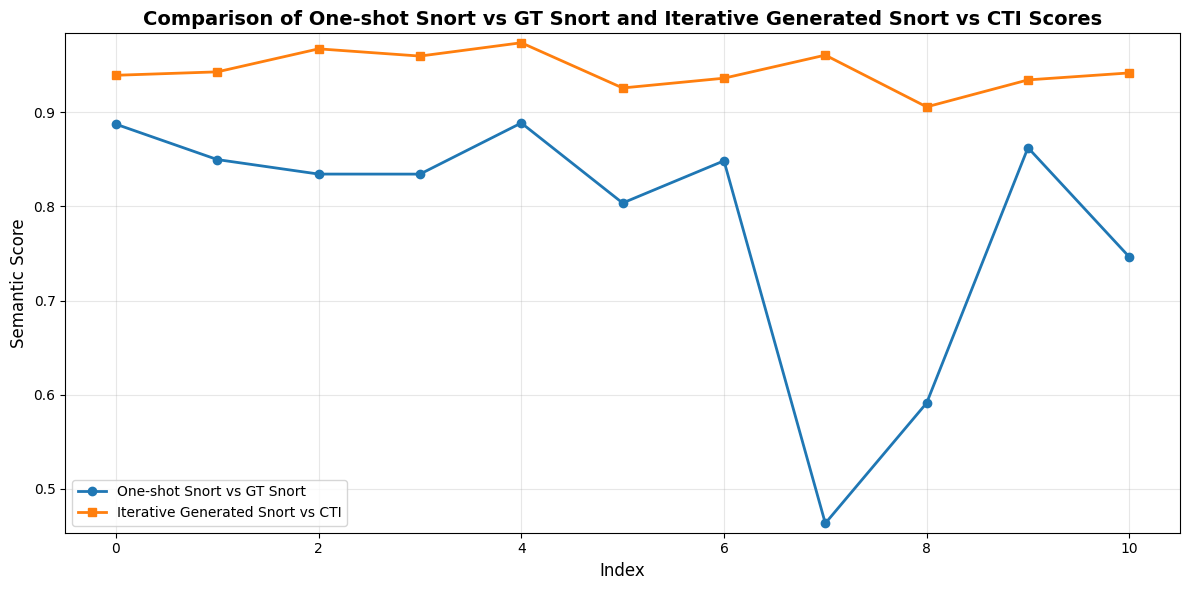

One-shot scores - Mean: 0.7827, Min: 0.4635, Max: 0.8886
Final scores - Mean: 0.9442, Min: 0.9056, Max: 0.9737


In [11]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))

# Plot both score lines
x_indices = range(len(one_shot_cti_rule_scores))
plt.plot(
    x_indices,
    one_shot_cti_rule_scores,
    marker="o",
    label="One-shot Snort vs GT Snort",
    linewidth=2,
    markersize=6,
)
plt.plot(
    x_indices,
    final_gen_cti_rule_scores,
    marker="s",
    label="Iterative Generated Snort vs CTI",
    linewidth=2,
    markersize=6,
)

# Set y-axis range based on min and max values
all_scores = one_shot_cti_rule_scores + final_gen_cti_rule_scores
y_min = min(all_scores) - 0.01
y_max = max(all_scores) + 0.01
plt.ylim(y_min, y_max)

# Labels and title
plt.xlabel("Index", fontsize=12)
plt.ylabel("Semantic Score", fontsize=12)
plt.title(
    "Comparison of One-shot Snort vs GT Snort and Iterative Generated Snort vs CTI Scores",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

# Print statistics
print(
    f"One-shot scores - Mean: {sum(one_shot_cti_rule_scores)/len(one_shot_cti_rule_scores):.4f}, Min: {min(one_shot_cti_rule_scores):.4f}, Max: {max(one_shot_cti_rule_scores):.4f}"
)
print(
    f"Final scores - Mean: {sum(final_gen_cti_rule_scores)/len(final_gen_cti_rule_scores):.4f}, Min: {min(final_gen_cti_rule_scores):.4f}, Max: {max(final_gen_cti_rule_scores):.4f}"
)

In [16]:
cti_vs_one_shot_rules = []
cti_vs_final_rules = []
gt_rule_vs_one_shot_rules = []
gt_rule_vs_final_rules = []
for cti, gt_rule, one_shot_rule, final_gen_rule in zip(
    iterative_refined_ctis,
    gt_rules,
    one_shot_rules,
    final_gen_rules,
):
    cti_vs_one_shot_rules.append(
        snort_semantic_evaluator(
            one_shot_rule,
            [cti],
            model=cti_rule_semantic_model,
            tokenizer=cti_rule_semantic_tokenizer,
        )["scores"][0]
    )
    cti_vs_final_rules.append(
        snort_semantic_evaluator(
            final_gen_rule,
            [cti],
            model=cti_rule_semantic_model,
            tokenizer=cti_rule_semantic_tokenizer,
        )["scores"][0]
    )
    gt_rule_vs_one_shot_rules.append(
        snort_semantic_evaluator(
            one_shot_rule,
            [gt_rule],
            model=cti_rule_semantic_model,
            tokenizer=cti_rule_semantic_tokenizer,
        )["scores"][0]
    )
    gt_rule_vs_final_rules.append(
        snort_semantic_evaluator(
            final_gen_rule,
            [gt_rule],
            model=cti_rule_semantic_model,
            tokenizer=cti_rule_semantic_tokenizer,
        )["scores"][0]
    )

In [ ]:
lengths = {
    "cti_vs_one_shot_rules": len(cti_vs_one_shot_rules),
    "cti_vs_final_rules": len(cti_vs_final_rules),
    "gt_rule_vs_one_shot_rules": len(gt_rule_vs_one_shot_rules),
    "gt_rule_vs_final_rules": len(gt_rule_vs_final_rules),
}

all_equal = len(set(lengths.values())) == 1

if all_equal:
    # Print True and the common length
    common_length = next(iter(set(lengths.values())))
    print(True, common_length)
else:
    # Print False and each length for debugging
    print(False)
    for name, ln in lengths.items():
        print(f"{name}: {ln}")

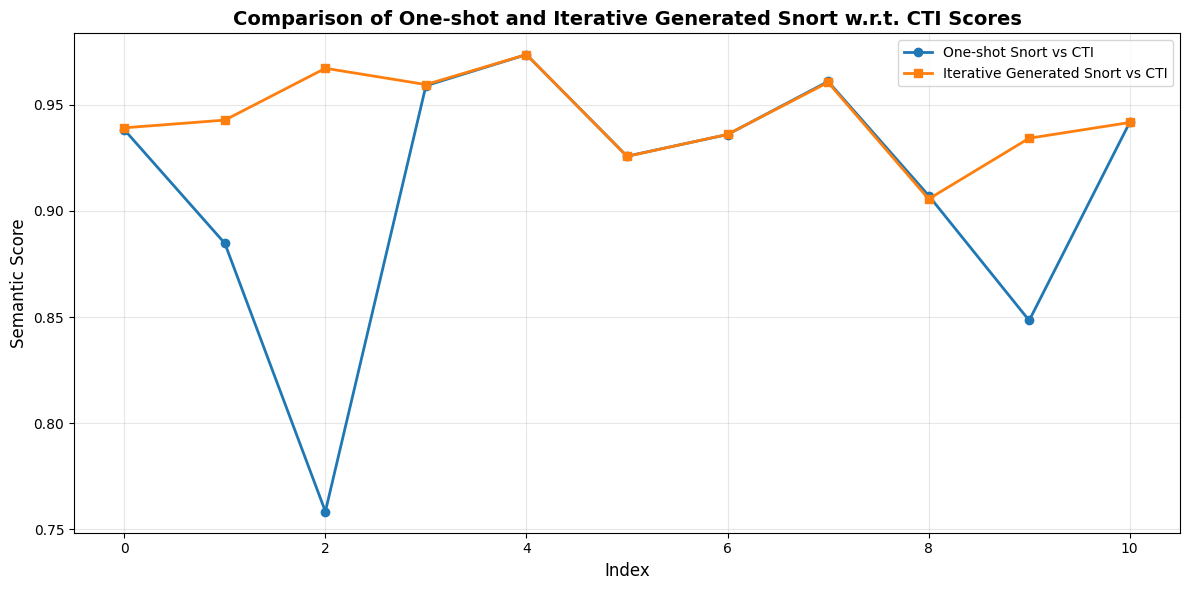

One-shot scores - Mean: 0.9122, Min: 0.7583, Max: 0.9737
Final scores - Mean: 0.9442, Min: 0.9056, Max: 0.9737


In [14]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))

# Plot both score lines
x_indices = range(len(cti_vs_one_shot_rules))
plt.plot(
    x_indices,
    cti_vs_one_shot_rules,
    marker="o",
    label="One-shot Snort vs CTI",
    linewidth=2,
    markersize=6,
)
plt.plot(
    x_indices,
    cti_vs_final_rules,
    marker="s",
    label="Iterative Generated Snort vs CTI",
    linewidth=2,
    markersize=6,
)

# Set y-axis range based on min and max values
all_scores = cti_vs_one_shot_rules + cti_vs_final_rules
y_min = min(all_scores) - 0.01
y_max = max(all_scores) + 0.01
plt.ylim(y_min, y_max)

# Labels and title
plt.xlabel("Index", fontsize=12)
plt.ylabel("Semantic Score", fontsize=12)
plt.title(
    "Comparison of One-shot and Iterative Generated Snort w.r.t. CTI Scores",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

# Print statistics
print(
    f"One-shot scores - Mean: {sum(cti_vs_one_shot_rules)/len(cti_vs_one_shot_rules):.4f}, Min: {min(cti_vs_one_shot_rules):.4f}, Max: {max(cti_vs_one_shot_rules):.4f}"
)
print(
    f"Final scores - Mean: {sum(cti_vs_final_rules)/len(cti_vs_final_rules):.4f}, Min: {min(cti_vs_final_rules):.4f}, Max: {max(cti_vs_final_rules):.4f}"
)

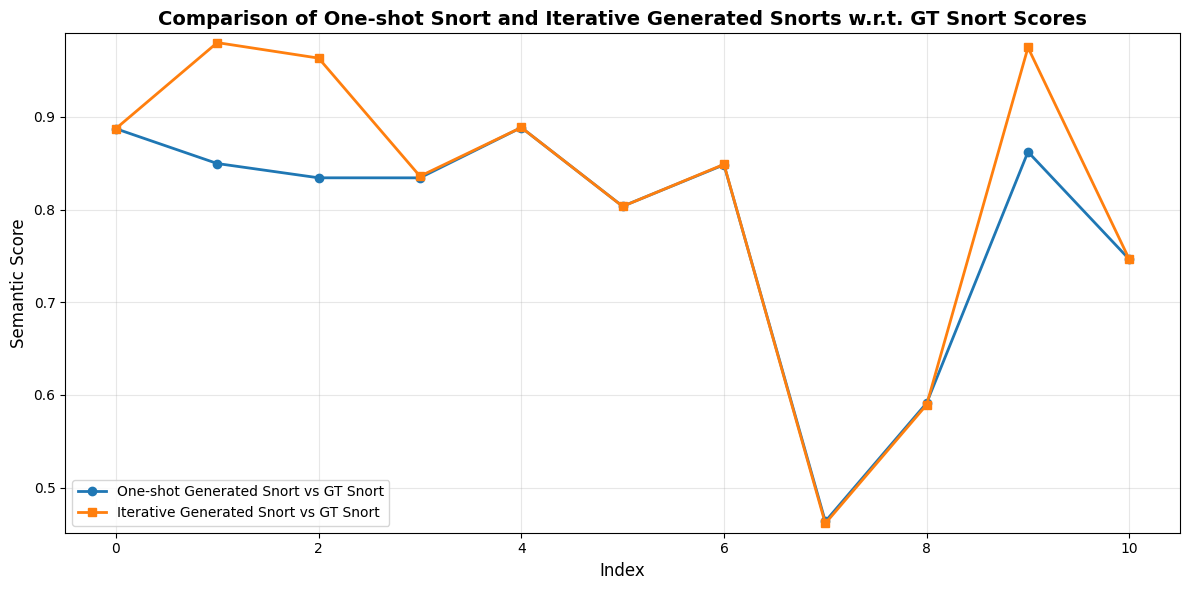

One-shot scores - Mean: 0.7827, Min: 0.4635, Max: 0.8886
Final scores - Mean: 0.8164, Min: 0.4613, Max: 0.9802


In [15]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))

# Plot both score lines
x_indices = range(len(gt_rule_vs_one_shot_rules))
plt.plot(
    x_indices,
    gt_rule_vs_one_shot_rules,
    marker="o",
    label="One-shot Generated Snort vs GT Snort",
    linewidth=2,
    markersize=6,
)
plt.plot(
    x_indices,
    gt_rule_vs_final_rules,
    marker="s",
    label="Iterative Generated Snort vs GT Snort",
    linewidth=2,
    markersize=6,
)

# Set y-axis range based on min and max values
all_scores = gt_rule_vs_one_shot_rules + gt_rule_vs_final_rules
y_min = min(all_scores) - 0.01
y_max = max(all_scores) + 0.01
plt.ylim(y_min, y_max)

# Labels and title
plt.xlabel("Index", fontsize=12)
plt.ylabel("Semantic Score", fontsize=12)
plt.title(
    "Comparison of One-shot Snort and Iterative Generated Snorts w.r.t. GT Snort Scores",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

# Print statistics
print(
    f"One-shot scores - Mean: {sum(gt_rule_vs_one_shot_rules)/len(gt_rule_vs_one_shot_rules):.4f}, Min: {min(gt_rule_vs_one_shot_rules):.4f}, Max: {max(gt_rule_vs_one_shot_rules):.4f}"
)
print(
    f"Final scores - Mean: {sum(gt_rule_vs_final_rules)/len(gt_rule_vs_final_rules):.4f}, Min: {min(gt_rule_vs_final_rules):.4f}, Max: {max(gt_rule_vs_final_rules):.4f}"
)

# All Iterative Inference

In [76]:
iterative_refined_ctis = []
gt_rules = []
one_shot_rules = []
one_shot_cti_rule_scores = []
final_gen_rules = []
final_gen_cti_rule_scores = []
for gen_rule in generated_rules:
    if (
        gen_rule["final_inference"]["no_of_retries"] > 0
        and gen_rule["final_inference"]["status"] == True
        # and gen_rule["one_shot_inference"]["feedback"]["semantic"][0]["scores"][0]
        # != gen_rule["final_inference"]["feedback"]["semantic"][-1]["scores"][0]
    ):
        iterative_refined_ctis.append(gen_rule["cti"])
        gt_rules.append(gen_rule["ground_truth_rule"])
        one_shot_rules.append(gen_rule["one_shot_inference"]["generated_rule"])
        one_shot_cti_rule_scores.append(
            gen_rule["one_shot_inference"]["feedback"]["semantic"][0]["scores"][0]
        )
        final_gen_rules.append(gen_rule["final_inference"]["generated_rule"])
        final_gen_cti_rule_scores.append(
            gen_rule["final_inference"]["feedback"]["semantic"][-1]["scores"][0]
        )

In [ ]:
lengths = {
    "iterative_refined_ctis": len(iterative_refined_ctis),
    "gt_rules": len(gt_rules),
    "one_shot_rules": len(one_shot_rules),
    "one_shot_cti_rule_scores": len(one_shot_cti_rule_scores),
    "final_gen_rules": len(final_gen_rules),
    "final_gen_cti_rule_scores": len(final_gen_cti_rule_scores),
}

all_equal = len(set(lengths.values())) == 1

if all_equal:
    # Print True and the common length
    common_length = next(iter(set(lengths.values())))
    print(True, common_length)
else:
    # Print False and each length for debugging
    print(False)
    for name, ln in lengths.items():
        print(f"{name}: {ln}")

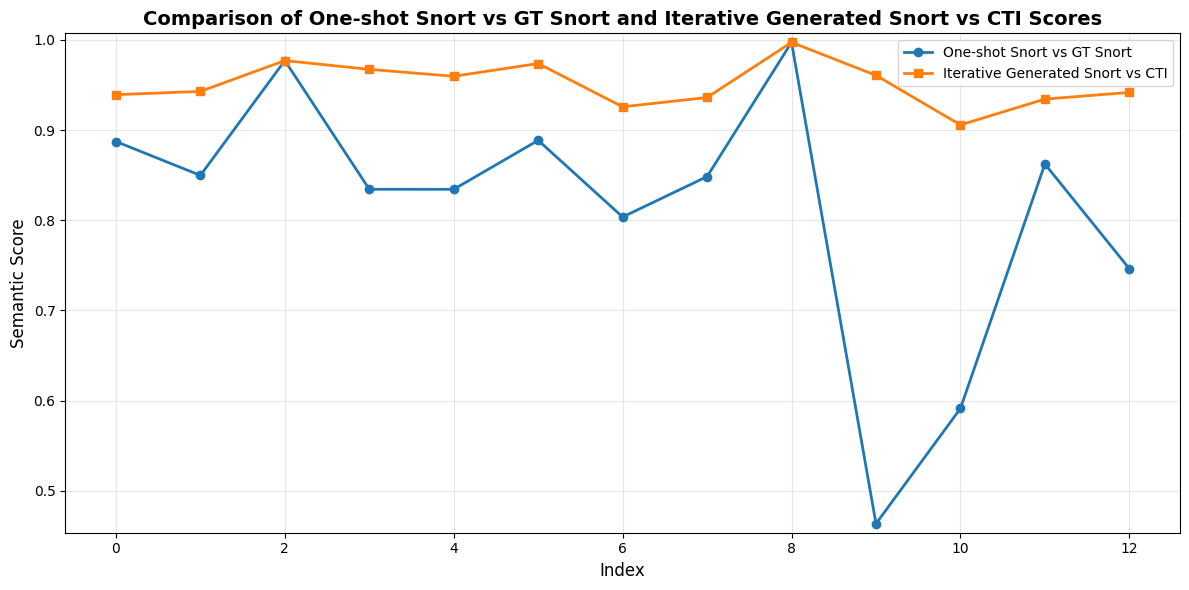

One-shot scores - Mean: 0.8141, Min: 0.4635, Max: 0.9972
Final scores - Mean: 0.9508, Min: 0.9056, Max: 0.9972


In [114]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))

# Plot both score lines
x_indices = range(len(one_shot_cti_rule_scores))
plt.plot(
    x_indices,
    one_shot_cti_rule_scores,
    marker="o",
    label="One-shot Snort vs GT Snort",
    linewidth=2,
    markersize=6,
)
plt.plot(
    x_indices,
    final_gen_cti_rule_scores,
    marker="s",
    label="Iterative Generated Snort vs CTI",
    linewidth=2,
    markersize=6,
)

# Set y-axis range based on min and max values
all_scores = one_shot_cti_rule_scores + final_gen_cti_rule_scores
y_min = min(all_scores) - 0.01
y_max = max(all_scores) + 0.01
plt.ylim(y_min, y_max)

# Labels and title
plt.xlabel("Index", fontsize=12)
plt.ylabel("Semantic Score", fontsize=12)
plt.title(
    "Comparison of One-shot Snort vs GT Snort and Iterative Generated Snort vs CTI Scores",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

# Print statistics
print(
    f"One-shot scores - Mean: {sum(one_shot_cti_rule_scores)/len(one_shot_cti_rule_scores):.4f}, Min: {min(one_shot_cti_rule_scores):.4f}, Max: {max(one_shot_cti_rule_scores):.4f}"
)
print(
    f"Final scores - Mean: {sum(final_gen_cti_rule_scores)/len(final_gen_cti_rule_scores):.4f}, Min: {min(final_gen_cti_rule_scores):.4f}, Max: {max(final_gen_cti_rule_scores):.4f}"
)

In [88]:
cti_vs_one_shot_rules = []
cti_vs_final_rules = []
gt_rule_vs_one_shot_rules = []
gt_rule_vs_final_rules = []
for cti, gt_rule, one_shot_rule, final_gen_rule in zip(
    iterative_refined_ctis,
    gt_rules,
    one_shot_rules,
    final_gen_rules,
):
    cti_vs_one_shot_rules.append(
        snort_semantic_evaluator(
            one_shot_rule,
            [cti],
            model=cti_rule_semantic_model,
            tokenizer=cti_rule_semantic_tokenizer,
        )["scores"][0]
    )
    cti_vs_final_rules.append(
        snort_semantic_evaluator(
            final_gen_rule,
            [cti],
            threshold=min_semantic_score_threshold,
            model=cti_rule_semantic_model,
            tokenizer=cti_rule_semantic_tokenizer,
        )["scores"][0]
    )
    gt_rule_vs_one_shot_rules.append(
        snort_semantic_evaluator(
            one_shot_rule,
            [gt_rule],
            threshold=min_semantic_score_threshold,
            model=cti_rule_semantic_model,
            tokenizer=cti_rule_semantic_tokenizer,
        )["scores"][0]
    )
    gt_rule_vs_final_rules.append(
        snort_semantic_evaluator(
            final_gen_rule,
            [gt_rule],
            threshold=min_semantic_score_threshold,
            model=cti_rule_semantic_model,
            tokenizer=cti_rule_semantic_tokenizer,
        )["scores"][0]
    )

In [ ]:
lengths = {
    "cti_vs_one_shot_rules": len(cti_vs_one_shot_rules),
    "cti_vs_final_rules": len(cti_vs_final_rules),
    "gt_rule_vs_one_shot_rules": len(gt_rule_vs_one_shot_rules),
    "gt_rule_vs_final_rules": len(gt_rule_vs_final_rules),
}

all_equal = len(set(lengths.values())) == 1

if all_equal:
    # Print True and the common length
    common_length = next(iter(set(lengths.values())))
    print(True, common_length)
else:
    # Print False and each length for debugging
    print(False)
    for name, ln in lengths.items():
        print(f"{name}: {ln}")

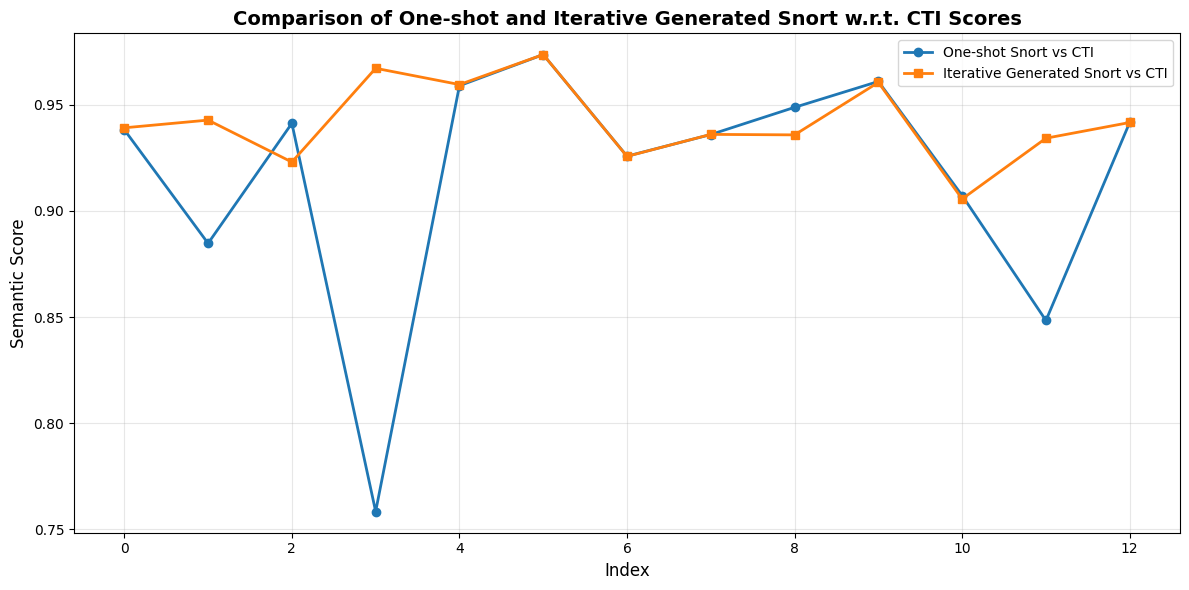

One-shot scores - Mean: 0.9173, Min: 0.7583, Max: 0.9737
Final scores - Mean: 0.9420, Min: 0.9056, Max: 0.9737


In [115]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))

# Plot both score lines
x_indices = range(len(cti_vs_one_shot_rules))
plt.plot(
    x_indices,
    cti_vs_one_shot_rules,
    marker="o",
    label="One-shot Snort vs CTI",
    linewidth=2,
    markersize=6,
)
plt.plot(
    x_indices,
    cti_vs_final_rules,
    marker="s",
    label="Iterative Generated Snort vs CTI",
    linewidth=2,
    markersize=6,
)

# Set y-axis range based on min and max values
all_scores = cti_vs_one_shot_rules + cti_vs_final_rules
y_min = min(all_scores) - 0.01
y_max = max(all_scores) + 0.01
plt.ylim(y_min, y_max)

# Labels and title
plt.xlabel("Index", fontsize=12)
plt.ylabel("Semantic Score", fontsize=12)
plt.title(
    "Comparison of One-shot and Iterative Generated Snort w.r.t. CTI Scores",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

# Print statistics
print(
    f"One-shot scores - Mean: {sum(cti_vs_one_shot_rules)/len(cti_vs_one_shot_rules):.4f}, Min: {min(cti_vs_one_shot_rules):.4f}, Max: {max(cti_vs_one_shot_rules):.4f}"
)
print(
    f"Final scores - Mean: {sum(cti_vs_final_rules)/len(cti_vs_final_rules):.4f}, Min: {min(cti_vs_final_rules):.4f}, Max: {max(cti_vs_final_rules):.4f}"
)

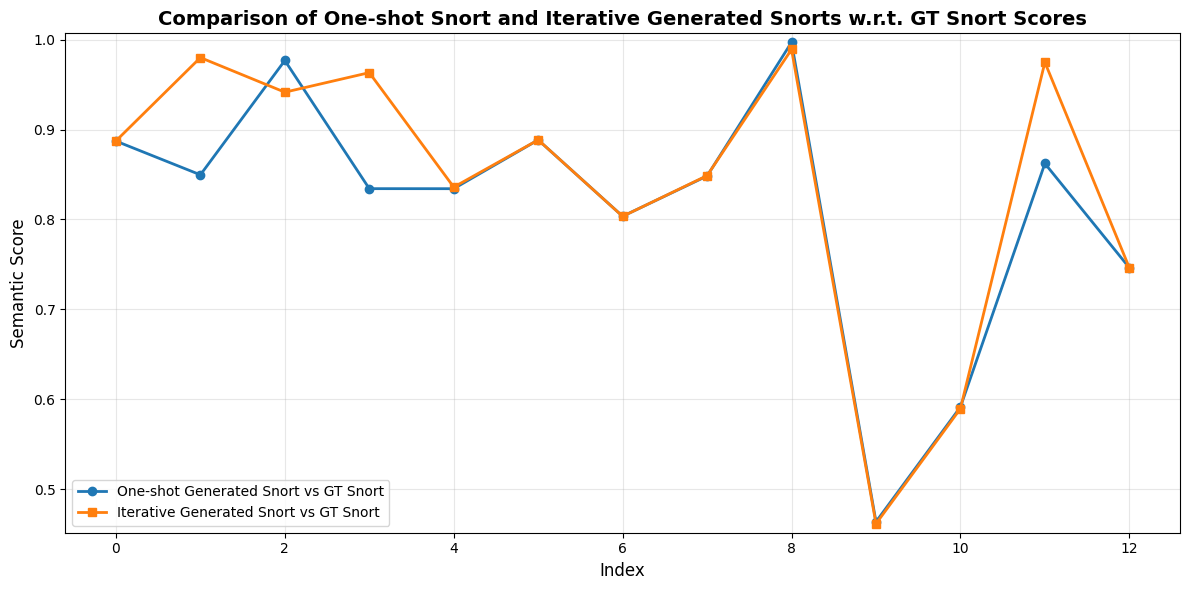

One-shot scores - Mean: 0.8141, Min: 0.4635, Max: 0.9972
Final scores - Mean: 0.8393, Min: 0.4613, Max: 0.9892


In [116]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))

# Plot both score lines
x_indices = range(len(gt_rule_vs_one_shot_rules))
plt.plot(
    x_indices,
    gt_rule_vs_one_shot_rules,
    marker="o",
    label="One-shot Generated Snort vs GT Snort",
    linewidth=2,
    markersize=6,
)
plt.plot(
    x_indices,
    gt_rule_vs_final_rules,
    marker="s",
    label="Iterative Generated Snort vs GT Snort",
    linewidth=2,
    markersize=6,
)

# Set y-axis range based on min and max values
all_scores = gt_rule_vs_one_shot_rules + gt_rule_vs_final_rules
y_min = min(all_scores) - 0.01
y_max = max(all_scores) + 0.01
plt.ylim(y_min, y_max)

# Labels and title
plt.xlabel("Index", fontsize=12)
plt.ylabel("Semantic Score", fontsize=12)
plt.title(
    "Comparison of One-shot Snort and Iterative Generated Snorts w.r.t. GT Snort Scores",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

# Print statistics
print(
    f"One-shot scores - Mean: {sum(gt_rule_vs_one_shot_rules)/len(gt_rule_vs_one_shot_rules):.4f}, Min: {min(gt_rule_vs_one_shot_rules):.4f}, Max: {max(gt_rule_vs_one_shot_rules):.4f}"
)
print(
    f"Final scores - Mean: {sum(gt_rule_vs_final_rules)/len(gt_rule_vs_final_rules):.4f}, Min: {min(gt_rule_vs_final_rules):.4f}, Max: {max(gt_rule_vs_final_rules):.4f}"
)